In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import time

/localhome/iaga_dv/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now we create different test data for computing the kernel sizes on.

In [2]:
#test data stuff - to go to dataloader
def gaussian_disk():
    """
        Generate a random point in the unit disk using Gaussian sampling.
    """
    point = np.random.normal(loc=0.0, scale=1.0, size=2)
    norm_point = np.linalg.norm(point)
    scaled_point = point / norm_point * np.random.uniform(0, 1)**(1/2)
    return scaled_point

def gaussian_ball():
    """
        Generate a random point in the 3D unit ball using Gaussian sampling.
    """
    point = np.random.normal(loc=0.0, scale=1.0, size=3)
    norm_point = np.linalg.norm(point)
    scaled_point = point / norm_point * np.random.uniform(0, 1)**(1/3)
    return scaled_point

def uniform_ball():
    """
        Generate a random point in the unit ball using uniform sampling with respect to the l2 norm.
    """
    point = np.random.uniform(low=-1.0, high=1.0, size=3)
    norm_point = np.linalg.norm(point, ord=2)
    scaled_point = point / norm_point* np.random.uniform(0, 1)**(1/3)
    return scaled_point

# Function to generate random points within a 3D ball of radius R
def random_uni_points_in_ball(R, num_points, center = (0, 0, 0), dim=3):
    """
        Generate random points uniformly distributed in a ball of radius R in 'dim' dimensions.
    """
    points = []
    for _ in range(num_points):
        # generate a random point from a 3D Gaussian distribution
        point = uniform_ball()
        # scale the point to be within the ball
        scaled_point = R*point
        points.append(scaled_point)
    return np.array(points)

def cutoff_and_rescale_noise(noise, cutoff_radius):
    """
    Cutoff noise vectors that exceed the given radius and rescale them.

    Arguments:
    - noise: (N, d) array of sampled noise vectors.
    - cutoff_radius: The threshold norm for noise.

    Returns:
    - Adjusted noise with norm constraint.
    """
    norms = np.linalg.norm(noise, axis=1)
    mask = norms > cutoff_radius  # Identify outliers

    # Rescale the noise vectors that exceed the cutoff
    noise[mask] = noise[mask] / norms[mask, np.newaxis] * cutoff_radius

    return noise

# Function to generate random points within a 3D ball of radius R
def random_points_in_ball(R, num_points, center = (0, 0, 0), dim=3):
    """
        Generate random points uniformly distributed in a ball of radius R in 'dim' dimensions.
    """
    points = []
    for _ in range(num_points):
        # generate a random point from a 3D Gaussian distribution
        point = gaussian_ball()
        # scale the point to be within the ball
        scaled_point = R*point
        points.append(scaled_point)
    return np.array(points)


def random_points_in_ball_with_noise(R, num_points, noise_std=0.1, dim=3):
    """
        Generate random points uniformly distributed in a ball of radius R in 'dim' dimensions
        and add Gaussian noise.
    """
    points = random_points_in_ball(R, num_points, dim)
    noise = np.random.normal(0, noise_std, size=points.shape)
    noisy_points = points + noise
    return noisy_points

def random_points_in_ball_with_cutoff_noise(R, num_points, noise_std=0.1, cutoff=0.2, dim=3):
    """
    Generate random points uniformly distributed in a ball of radius R in 'dim' dimensions
    and add Gaussian noise with a cutoff and rescaling.

    Arguments:
    - R: Radius of the ball.
    - num_points: Number of points to generate.
    - noise_std: Standard deviation of the noise.
    - cutoff: Maximum allowable norm for noise.
    - dim: Dimensionality of the space (default 3).

    Returns:
    - Noisy points inside the ball with constrained noise.
    """
    points = random_points_in_ball(R, num_points, dim=dim)
    noise = np.random.normal(0, noise_std, size=points.shape)
    
    # Apply cutoff and rescaling
    noise = cutoff_and_rescale_noise(noise, cutoff)

    noisy_points = points + noise
    return noisy_points


# Function to generate random points in the disk of radius R - 2d or 3d
def random_points_in_disk(R, num_points):
    """
        Generate random points within a 2D disk using Gaussian sampling.

        Arguments:
        - radius: The radius of the disk.
        - num_points: Number of random points to sample.

        Returns:
        - points: Randomly sampled points within the disk.
    """
    points = []

    for _ in range(num_points):
        # generate a random point from a 2D Gaussian distribution
        point = gaussian_disk()
        # scale the point to be within the disk
        scaled_point = R*point
        points.append(scaled_point)
    # Return points as an array of shape (num_points, 2)
    return np.array(points)

def random_points_in_disk_with_noise(R, num_points, noise_std=0.1):
    """
        Generate random points within a 2D disk and add Gaussian noise.
    """
    points = random_points_in_disk(R, num_points)
    noise = np.random.normal(0, noise_std, size=points.shape)
    noisy_points = points + noise
    return noisy_points

def random_points_in_disk_with_cutoff_noise(R, num_points, noise_std=0.1, cutoff=0.2):
    """
    Generate random points uniformly distributed in a disk of radius R in '2D' dimensions
    and add Gaussian noise with a cutoff and rescaling.

    Arguments:
    - R: Radius of the disk.
    - num_points: Number of points to generate.
    - noise_std: Standard deviation of the noise.
    - cutoff: Maximum allowable norm for noise.

    Returns:
    - Noisy points inside the disk with constrained noise.
    """
    points = random_points_in_disk(R, num_points)
    noise = np.random.normal(0, noise_std, size=points.shape)
    
    # Apply cutoff and rescaling
    noise = cutoff_and_rescale_noise(noise, cutoff)

    noisy_points = points + noise
    return noisy_points

def random_points_in_ellipse(a, b, num_points):
    """
        Generate random points within a 2D ellipse using Gaussian sampling.

        Arguments:
        - a: Semi-major axis length.
        - b: Semi-minor axis length.
        - num_points: Number of random points to sample.

        Returns:
        - points: Randomly sampled points within the ellipse.
    """
    points = []
    for _ in range(num_points):
        gaussian_point = gaussian_disk()
        ellipse_point = np.array([a*gaussian_point[0], b*gaussian_point[1]])
        points.append(ellipse_point)
    return np.array(points)

def random_points_in_ellipse_with_noise(a, b, num_points, noise_std=0.1):
    """
        Generate random points within a 2D ellipse and add Gaussian noise.
    """
    points = random_points_in_ellipse(a, b, num_points)
    noise = np.random.normal(0, noise_std, size=points.shape)
    noisy_points = points + noise
    return noisy_points

def random_points_in_ellipsoid(a, b, c, num_points):
    """
        Generate random points within a 3D ellipsoid using Gaussian sampling.

        Arguments:
        - a: Semi-principal axis along the x-axis.
        - b: Semi-principal axis along the y-axis.
        - c: Semi-principal axis along the z-axis.
        - num_points: Number of random points to sample.

        Returns:
        - points: Randomly sampled points within the ellipsoid.
    """
    points = []
    for _ in range(num_points):
        gaussian_point = gaussian_ball()
        ellipsoid_point = np.array([a*gaussian_point[0], b*gaussian_point[1], c*gaussian_point[2]])
        points.append(ellipsoid_point)
    return np.array(points)

def random_points_in_ellipsoid_with_noise(a, b, c, num_points, noise_std=0.1):
    """
        Generate random points within a 3D ellipsoid and add Gaussian noise.
    """
    points = random_points_in_ellipsoid(a, b, c, num_points)
    noise = np.random.normal(0, noise_std, size=points.shape)
    noisy_points = points + noise
    return noisy_points

def random_points_in_ellipsoid_with_cutoff_noise(a, b, c, num_points, noise_std=0.1, cutoff=0.2):
    """
    Generate random points in an ellipsoid and add Gaussian noise with cutoff and rescaling.

    Arguments:
    - a, b, c: Semi-axes of the ellipsoid.
    - num_points: Number of points to generate.
    - noise_std: Standard deviation of the noise.
    - cutoff: Maximum allowable norm for noise.

    Returns:
    - Noisy points inside the ellipsoid with constrained noise.
    """
    points = random_points_in_ellipsoid(a, b, c, num_points)
    noise = np.random.normal(0, noise_std, size=points.shape)
    
    # Apply cutoff and rescaling
    noise = cutoff_and_rescale_noise(noise, cutoff)

    noisy_points = points + noise
    return noisy_points

In [3]:
#subsample k points from array
def subsample_points(input_data, number_samples):
    """ Subsample k points from input data"""

In [4]:
# Function to apply matrix transformation A to points
def apply_forwardmodel(A, points):
    return np.dot(points, A.T)

def projection_nullspace_operator(A):
    """Compute the matrix for projecting onto the null space of a matrix A, i.e. P_{N(A)}= (I - A^dagger A)
    Args: 
        - A: matrix 
    Returns:
        - project_ns: matrix projecting onto the null space of A.
    """
    A_dagger = np.linalg.pinv(A)
    project_ns= np.eye(A.shape[1]) - np.dot(A_dagger, A)
    return project_ns


def projection_nullspace(A, x):
    """
        Compute the projection of a point x onto the null space of A, i.e., P_{N(A)}(x).
        This is equivalent to (I - A^dagger A) x usin the function projection_nullspace for computing P_{N(A)} from A.
    """
    project_ns = projection_nullspace_operator(A)
    x_ns = np.dot(project_ns,x)
    
    return x_ns

In [5]:
def compute_feasible_set(A, input_data_point, target_data, q, epsilon):
    """
    Implements the iterative algorithm for estimating feasible sets for one input point based on possible target data points for a noisy inverse problem. 
        Arguments:
        - A: The matrix (for which we are computing the Moore-Penrose inverse) of the inverse problem input_data = A(target_data)+noise.
        - input_data_point: Input data point, referred to as "y" in variable names, for an approximate inverse method.
        - target_data: Target or ground truth data for an approximate inverse method.
        - q: order of the norm on the input dataset, default q=2 for MSE computation.
        - epsilon: Noise level in the inverse problem input_data = A(target_data)+noise.

        Returns:
        - feas_set_approx: approximation to the feasible set, consisting of all target data points that can map to an input data point within the noise level.
    """

    # Step 2: Compute feasible set for input data point y
    feas_set_y = []

    for x_n in target_data:
        e_n = input_data_point - np.dot(A,x_n) # Compute noise vector

        if np.linalg.norm(e_n,q) <= epsilon:  # Check if noise is below noiselevel
            # add traget data point x_n to feasible set
            feas_set_y.append(x_n)

    return feas_set_y

In [6]:
def diams_feasibleset_inv(A, input_data_point, target_data, p, epsilon):
    """
    Implements the iterative algorithm for diameter estimation of the feasible set for a noisy inverse problem. 
    Computes diameter based on possible target data points for one input point.
        Arguments:
        - A: The matrix (for which we are computing the Moore-Penrose inverse) of the inverse problem input_data = A(target_data)+noise.
        - input_data_point: Input data point, referred to as "y" in variable names, for an approximate inverse method.
        - target_data: Target or ground truth data for an approximate inverse method.
        - p: order of the norm on the target dataset, default p=2 for MSE computation.
        - epsilon: Noise level in the inverse problem input_data = A(target_data)+noise.

        Returns:
        - diameter_mean_y, num_feas, max_diam_Fy: diameter_mean_y of dim(0)= shape(input_data), the estimated mean diameter of the feasible set, 
                                        consisting of all possible target data points, for one input point.
                                        num_feas is the number of samples in the feasible set and will be used for statistics later on.
                                        max_diam_Fy the maximum diameter of the feasible set, 
                                        consisting of all possible target data points, for one input point.
    """

    # Step 2: Compute feasible sets and diameters
    feas_set_y = compute_feasible_set(A, input_data_point, target_data, p, epsilon)
    max_diam_Fy = 0
    diameter_mean_y = 0
    diam_y = []
    # obtain number of samples in feasible set (num_feas will be used for statistics later on)
    num_feas = len(feas_set_y)

    # compute diameters
    for h in range(0,num_feas,1):
        for j in range(0,h+1,1):
            #compute vectors in null space of F and their norm
            dist_ns = feas_set_y[h]-feas_set_y[j]
            diameter= np.linalg.norm(dist_ns, ord = p)

            #add to diam_y 
            diam_y.append(diameter)

            #get ascending diams
            if diameter > max_diam_Fy:
                max_diam_Fy = diameter
                            
    # get mean over diams, with factor 2 due to symmetry of the norm of the compute vectors in null space of F (norm(x-z)=norm(z-x))
    # and divided by num_feas^2 ad we have that many terms
    if num_feas > 0:      
        # compute 2 times sum over diams to the power p divided by num_feas^2
        diameter_mean_y = 2*np.divide(np.sum(np.power(diam_y,p)), np.power(num_feas,2))
    elif num_feas==0:
        diameter_mean_y = 0  

    return diameter_mean_y, num_feas, max_diam_Fy

In [7]:
def diams_feasibleset_inv_sym(A, input_data_point, target_data, p,q, epsilon):
    """
    Implements the iterative algorithm for diameter estimation of the feasible set for a noisy inverse problem under the assumption that 
    there exists noise vectors such that the target data is symmetric with respect to the null space of F= (A |I): P_{N(F)^perp}(x,e)-P_{N(F)}(x,e). 
    Computes diameter based on possible target data points for one input point.
        Arguments:
        - A: The matrix (for which we are computing the Moore-Penrose inverse) of the inverse problem input_data = A(target_data)+noise.
        - input_data_point: Input data point, referred to as "y" in variable names, for an approximate inverse method.
        - target_data: Target or ground truth data for an approximate inverse method.
        - p: order of the norm on the target dataset, default p=2 for MSE computation.
        - q: order of norm on the input dataset.
        - epsilon: Noise level in the inverse problem input_data = A(target_data)+noise.

        Returns:
        - diameter_mean_y, num_feas, max_diam_Fy: diameter_mean_y of dim(0)= shape(input_data), the estimated mean diameter of the feasible set, 
                                        consisting of all possible target data points, for one input point.
                                        num_feas is the number of samples in the feasible set and will be used for statistics later on.
                                        max_diam_Fy the maximum diameter of the feasible set, 
                                        consisting of all possible target data points, for one input point.
    """
    # Compute Moore-Penrose-Inverse of F
    F = np.hstack((A, np.eye(A.shape[0])))  # Construct F: (A | I) 
    proj_ns_F = projection_nullspace_operator(F)

    # Step 2: Compute feasible sets and diameters
    max_diam_Fy = 0
    diameter_mean_y = 0
    diam_y = []

    for x_n in target_data:
        xcomp = len(x_n)-1
        e_n = input_data_point - np.dot(A,x_n) # Compute noise vector

        if np.linalg.norm(e_n,q) <= epsilon:  # Check if noise is below noiselevel
            # Project onto the null space of F
            proj_nullspace = np.dot(proj_ns_F, np.hstack((x_n, e_n)))[0:xcomp] # Project (x_n, e_n) onto nullspace of F, only take dim of x_n

            # Compute diameter of feasible set based on projection onto null space
            diameter = 2 * np.linalg.norm(proj_nullspace, ord = p)   

            #add to diam_y 
            diam_y.append(diameter)

            #get ascending diams
            if diameter > max_diam_Fy:
                max_diam_Fy = diameter
                
    # obtain number of samples in feasible set (num_feas will be used for statistics later on)
    num_feas = len(diam_y)        
    # get mean over diams 
    if num_feas > 0:      
        diameter_mean_y = np.mean(np.power(diam_y,p))

    return diameter_mean_y, num_feas, max_diam_Fy

In [8]:
def wc_kernelsize(A, input_data, target_data, p,q, epsilon):
    """
    Computes the worst-case kernel size for noisy inverse problem using Algorithm 1.

    Args:
        - A: The matrix (for which we are computing the Moore-Penrose inverse) of the inverse problem input_data = A(target_data)+noise.
        - input_data: Input data for an approximate inverse method.
        - target_data: Target or ground truth data for an approximate inverse method.
        - p: order of the norm on the target dataset, default p=2 for MSE computation.
        - q: order of norm on the input dataset.
        - epsilon: Noise level in the inverse problem input_data = A(target_data)+noise.

    Returns:
        Approximate worst-case kernel size for a set of input data samples.
    """
    wc_kersize =0

    for y in input_data:
        # compute diameter of feasible set for one input data point
        diameter_mean_y, num_feas, max_diam_Fy = diams_feasibleset_inv(A, y, target_data, p, epsilon)
        if max_diam_Fy > wc_kersize:
            wc_kersize = max_diam_Fy
    
    return wc_kersize

In [9]:
def av_kernelsize(A, input_data, target_data, p,q, epsilon):
    """
    Computes the average kernel size for a noisy inverse problem under Algorithm 2.

    Args:
        - A: The matrix (for which we are computing the Moore-Penrose inverse) of the inverse problem input_data = A(target_data)+noise.
        - input_data: Input data for an approximate inverse method.
        - target_data: Target or ground truth data for an approximate inverse method.
        - p: order of the norm on the target dataset, default p=2 for MSE computation.
        - q: order of norm on the input dataset.
        - epsilon: Noise level in the inverse problem input_data = A(target_data)+noise.

    Returns:
        Approximate average kernel size for for a set of input data samples.
    """

    av_kersizep = 0
    num_samples = len(input_data)

    for y in input_data:
        # compute diameter of feasible set for one input data point (num_feas will be used for statistics later on)
        diameter_mean_y, num_feas, max_diam_Fy = diams_feasibleset_inv_sym(A, y, target_data, p,q, epsilon)
        #add diameters means for obtaining average kersize to the power p
        av_kersizep = av_kersizep + diameter_mean_y
        
    # get mean over input data
    av_kersize = np.divide(av_kersizep, num_samples)    
    # take power 1/p to obtain average kersize
    av_kersize =  np.power(av_kersize, 1/p)
    
    return av_kersize


In [10]:
def plot_wckersize_conv(wc_kersizef, kersize_approxis, ker_size, max_k):

    # Plot results
    x_axis = np.arange(2, max_k+1)
    y_axis = np.array(kersize_approxis)
    plt.plot(x_axis, y_axis)
    plt.axhline(ker_size, color='r')
    plt.ylim(0, ker_size + 0.1 * ker_size)
    plt.grid()
    plt.xlabel("Number of samples")
    plt.ylabel("Approximate  wc kernel size")
    plt.title("Number of Samples vs wc Kernel Size")
    plt.show()

    #max_diameter_total = max(max_diameters)
    print(f"Total Max Kernel Size: { wc_kersizef}")
    print(f"Analytical Kernel Size: {ker_size}")
    rel_error = (wc_kersizef - ker_size) / ker_size
    print(f"Relative Error: {rel_error}")

In [11]:
def plot_times_comput(n_iter_list, times_comput):
    plt.plot(n_iter_list, times_comput, color = 'red')
    plt.title('Times of computation')
    plt.xlabel('Number of samples')
    plt.ylabel('t in seconds')
    plt.grid()
    plt.show()
    print(f'The last kernel size computation took {times_comput[-1]:6f} seconds')


In [12]:
def plot_avkersize_conv(av_kersize, av_kersizes, ker_size, max_k):

    # Plot results
    x_axis = np.arange(2, max_k+1)
    y_axis = np.array(av_kersizes)
    plt.plot(x_axis, y_axis)
    plt.axhline(ker_size, color='r')
    plt.ylim(0, ker_size + 0.3 * ker_size)
    plt.grid()
    plt.xlabel("Number of samples")
    plt.ylabel("Approximate average kernel size")
    plt.title("Number of Samples vs Av. Kernel Size")
    plt.show()

    #max_diameter_total = max(max_diameters)
    print(f"Total Max Kernel Size: {av_kersize}")
    print(f"Analytical Kernel Size: {ker_size}")
    rel_error = (av_kersize - ker_size) / ker_size
    print(f"Relative Error: {rel_error}")

In [13]:
def av_kersizes_over_samples_sizes(A, input_data_loads, target_data, p,q, epsilon):
    """Computes the average kernel size for a noisy inverse problem under Algorithm 2.
        Args:
            - A: The matrix (for which we are computing the Moore-Penrose inverse) of the inverse problem input_data = A(target_data)+noise.
            - input_data: Input data for an approximate inverse method.
            - target_data: Target or ground truth data for an approximate inverse method.
            - p: order of the norm on the target dataset, default p=2 for MSE computation.
            - q: order of norm on the input dataset.
            - epsilon: Noise level in the inverse problem input_data = A(target_data)+noise.
        Returns:
            Average kernel sizes for sample sizes of input data. """
    
    av_kersizes =[]

    for input_data in input_data_loads:
        av_kersize = av_kernelsize(A, input_data, target_data, p,q, epsilon)
        av_kersizes.append(av_kersize)
    
    return av_kersizes   

In [14]:
def wc_kersizes_over_samples_sizes(A, input_data_loads, target_data, p,q, epsilon):
    """Computes the worst-case kernel size for a noisy inverse problem under Algorithm 2.
        Args:
            - A: The matrix (for which we are computing the Moore-Penrose inverse) of the inverse problem input_data = A(target_data)+noise.
            - input_data: Input data for an approximate inverse method.
            - target_data: Target or ground truth data for an approximate inverse method.
            - p: order of the norm on the target dataset, default p=2 for MSE computation.
            - q: order of norm on the input dataset.
            - epsilon: Noise level in the inverse problem input_data = A(target_data)+noise.
        Returns:
            Worst-case kernel sizes for sample sizes of input data. """
    
    wc_kersizes =[]

    for input_data in input_data_loads:
        wc_kersize = wc_kernelsize(A, input_data, target_data, p,q, epsilon)
        wc_kersizes.append(wc_kersize)
    
    return wc_kersizes  

In [15]:
def wc_kernelsize_nosym_batch_cuda(A, input_data, target_data, p_X, p_Y, epsilon):
   

    # Convert input_data to torch tensor and move to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    x = torch.tensor(input_data, dtype=torch.float32, device=device)
    n = x.shape[0]
    # If x has shape (n, w, h, c, p), compute pairwise distances over all dimensions except the first
    # Flatten all but the first dimension for distance computation
    x_flat = x.reshape(n, -1)  # shape (n, D)
    diff = x_flat.unsqueeze(1) - x_flat.unsqueeze(0)  # shape (n, n, D)
    dist = torch.norm(diff, p=p_Y, dim=-1)  # shape (n, n)

    same_feasible = dist<2*epsilon

    # Now compute pairwise distances for target_data, but only where same_feasible is True
    target = torch.tensor(target_data, dtype=torch.float32, device=device)
    target_flat = target.reshape(target.shape[0], -1)  # shape (n, D)
    target_diff = target_flat.unsqueeze(1) - target_flat.unsqueeze(0)  # shape (n, n, D)
    target_dist = torch.norm(target_diff, p=p_X, dim=-1)  # shape (n, n)

    # Mask target_dist with same_feasible, use nan instead of 0
    masked_target_dist = torch.where(same_feasible, target_dist, torch.tensor(float('nan'), device=device))
    return np.nanmax(masked_target_dist.cpu().numpy())

In [39]:
def wc_kernelsize_sym_batch_cuda(A, F_null, input_data, target_data,forwarded_target, p_X, p_Y, epsilon):
    '''
    forwarded input has to be target_data@(A.T) , or equivalent. 
    It is frequently the same as input_data, but in the description of the algorithm, that is not necessary
    '''
    if F_null is None:
        # Compute Moore-Penrose-Inverse of F
        F = np.hstack((A, np.eye(A.shape[0])))  # Construct F: (A | I) 
        F_null = projection_nullspace_operator(F)  # to replace by the one in my class

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    x = torch.tensor(target_data, dtype=torch.float32, device=device)
    p = x.shape[0]
    n = x.shape[1]
    x_flat = x.reshape(p, -1)

    y = torch.tensor(input_data, dtype=torch.float32, device=device)
    q = y.shape[0]
    y_flat = y.reshape(q, -1)

    #A_t = torch.tensor(A, dtype = torch.float32).T
    e_diff = -forwarded_target[:,None, :] + y_flat[None, :,:] # Calculating e_{i,j} =  y_i- Ax_j for every i,j
    feasible_appartenance = torch.norm(e_diff,p = p_Y, dim = -1)<epsilon # x_j belongs in F_{y_i} iff feasible_appartenance[j,i] is true
    feasible_appartenance = feasible_appartenance.unsqueeze(-1)
    
    nanvals = torch.full_like(e_diff,float('nan'), device=device)
    e_diff = torch.where(feasible_appartenance, e_diff, nanvals) # Masking with nan (so that it can be reused easily for the average kernel size)
    
    x_exp = x_flat[:,None, :].expand(-1, q, -1)
    x_e_concat = torch.cat([x_exp, e_diff], dim = -1)  # Concatenating every x_i to each e_{i,j} 
    nm = x_e_concat.shape[-1]
 
    Fy_projs = x_e_concat.reshape(-1, nm)@(F_null.T) # Projectng each concatenation if they are in the feasible set. (if they are not, the concatenation will contain some nan and the operation will not be possible)
    Fy_projs = Fy_projs.reshape(p,q,nm)[:,:,:n]  # Only take the x part

    # it seems that torch.einsum('pqd,md->pqm', x_e_concat, F_null) coule be used, but i don't master it. I mention it because it looks fancy
    target_dists = 2*torch.norm(Fy_projs, p = p_X,dim = -1)
    return np.nanmax(target_dists.cpu().numpy()) 

In [32]:
def wc_kernelsize_nosym_crossbatch_cuda(A, batch1, batch2, p_X, p_Y, epsilon):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    input1, target1 = batch1
    input2,target2 = batch2

    y1 = torch.tensor(input1, dtype=torch.float32, device=device)
    n1 = y1.shape[0]
    y1_flat = y1.reshape(n1, -1)

    y2 = torch.tensor(input2, dtype=torch.float32, device=device)
    n2 = y2.shape[0]
    y2_flat = y2.reshape(n1, -1)

    cross_dist = torch.norm(y1_flat[:,None,:]-y2_flat[None,:,:], dim = -1, p = p_Y)
    same_feasible = cross_dist< 2*epsilon

    x1 = torch.tensor(target1, dtype=torch.float32, device=device)
    x1_flat = x1.reshape(n1, -1)

    x2 = torch.tensor(target2, dtype=torch.float32, device=device)
    x2_flat = x2.reshape(n1, -1)

    target_dists = torch.norm(x1_flat[:,None,:]-x2_flat[None,:,:], dim = -1, p = p_X)
    masked_target_dist = torch.where(same_feasible, target_dists, torch.tensor(float('nan'), device=device))

    return np.nanmax(masked_target_dist.cpu().numpy())


In [33]:
def wc_kernelsize_nosym_perbatch_cuda(A, input_data, target_data, p_X, p_Y, epsilon, batch_size):
    p = input_data.shape[0]
    n_batches = p//batch_size

    current_kersize = 0
    for i in range(n_batches):
        idx_imin = i*batch_size
        idx_imax = min(idx_imin+ batch_size, p)
        
        batch_i_current = (input_data[idx_imin:idx_imax], target_data[idx_imin:idx_imax])
        for j in range(i,n_batches):
            idx_jmin = j*batch_size
            idx_jmax = min(idx_jmin+ batch_size, p)

            batch_j_current = (input_data[idx_jmin:idx_jmax], target_data[idx_jmin:idx_jmax])
            
      
            if i==j:
                ks_batch = wc_kernelsize_nosym_batch_cuda(A, batch_i_current[0], batch_i_current[1], p_X = p_X, p_Y = p_Y, epsilon=epsilon)
            else:
                ks_batch = wc_kernelsize_nosym_crossbatch_cuda(A, batch_i_current, batch_j_current, p_X = p_X, p_Y = p_Y, epsilon=epsilon)
            if ks_batch >current_kersize:
                current_kersize = ks_batch
    return current_kersize


In [40]:
def wc_kernelsize_sym_crossbatch_cuda(A,F_null, batch1, batch2, p_X, p_Y, epsilon):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    input1, target1, forwarded_target1 = batch1
    input2,target2, forwarded_target2 = batch2

    return wc_kernelsize_sym_batch_cuda(A, F_null, input1, target2, forwarded_target2, p_X = p_X, p_Y = p_Y, epsilon = epsilon )


In [46]:
def wc_kernelsize_sym_perbatch_cuda(A, F_null, input_data, target_data, forwarded_target, p_X, p_Y, epsilon, batch_size):
    '''
    forwarded input has to be target_data@(A.T) , or equivalent. 
    It is frequently the same as input_data, but in the description of the algorithm, that is not necessary
    '''
    p = input_data.shape[0]
    n_batches = p//batch_size

    if F_null is None:
        # Compute Moore-Penrose-Inverse of F
        F = np.hstack((A, np.eye(A.shape[0])))  # Construct F: (A | I) 
        F_null = projection_nullspace_operator(F)  # to replace by the one in my class


    current_kersize = 0
    for i in range(n_batches):
        idx_imin = i*batch_size
        idx_imax = min(idx_imin+ batch_size, p)
        
        batch_i_current = (input_data[idx_imin:idx_imax], target_data[idx_imin:idx_imax], forwarded_target[idx_imin:idx_imax])
        for j in range(n_batches):
            idx_jmin = j*batch_size
            idx_jmax = min(idx_jmin+ batch_size, p)

            batch_j_current = (input_data[idx_jmin:idx_jmax], target_data[idx_jmin:idx_jmax], forwarded_target[idx_jmin:idx_jmax])
            
      
            if i==j:
                ks_batch = wc_kernelsize_sym_batch_cuda(A,F_null, batch_i_current[0], batch_i_current[1], batch_i_current[2], p_X = p_X, p_Y = p_Y, epsilon=epsilon)
            else:
                ks_batch = wc_kernelsize_sym_crossbatch_cuda(A, F_null,batch_i_current, batch_j_current, p_X = p_X, p_Y = p_Y, epsilon=epsilon)
            if ks_batch >current_kersize:
                current_kersize = ks_batch
    return current_kersize


# Tests

## Toy example 1 : 3D ball

### Worst case Kersize with symetric assumption, without parallelization

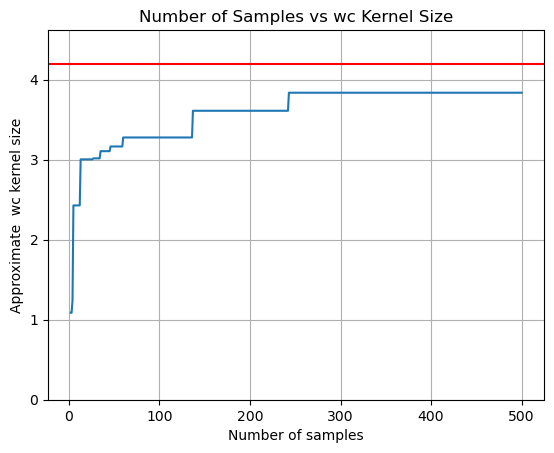

Total Max Kernel Size: 3.8374830487321403
Analytical Kernel Size: 4.2
Relative Error: -0.08631355982568092


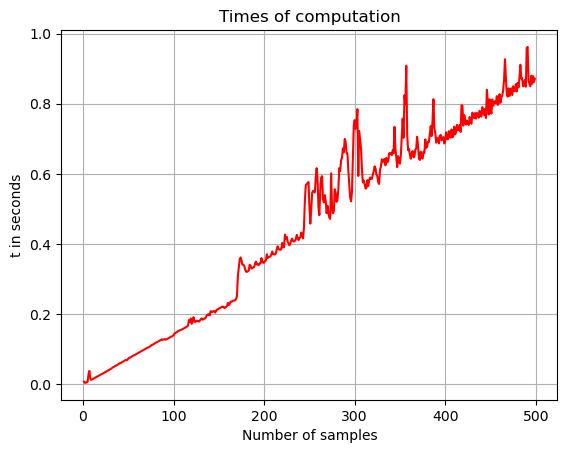

The last kernel size computation took 0.871457 seconds


In [27]:
# check if P_{N(A)}(M_1) of first toy example set is symmetric

# Toy example 1

R = 2  # Radius of the ball
num_points = 500  # Number of points in the set M_1
A = np.diag([1, 1, 0])  # Transformation matrix
p=2
q=2
epsilon=1e-1
#analytical kersize
ker_size = 2*R+2*epsilon


# Generate points in B_R(0)
target_data = random_points_in_ball(R+epsilon, num_points)
input_data =  apply_forwardmodel(A, target_data)

# Set the range of k values
max_k = 500

wc_kersizes = []
times_comput = []
for k in range(1,max_k,1):
    input_data_k = input_data[0:k,:]
    t0 = time.time()
    wc_kersize_k = wc_kernelsize(A, input_data_k, target_data, p,q, epsilon)
    t1 = time.time()
    times_comput.append(t1-t0)
    wc_kersizes.append(wc_kersize_k)

wc_kersizef = wc_kersizes[-1]

plot_wckersize_conv(wc_kersizef, wc_kersizes, ker_size, max_k)

plot_times_comput(list(range(1,max_k,1)), times_comput)


### Worst case Kersize without symetry assumption, parallelized

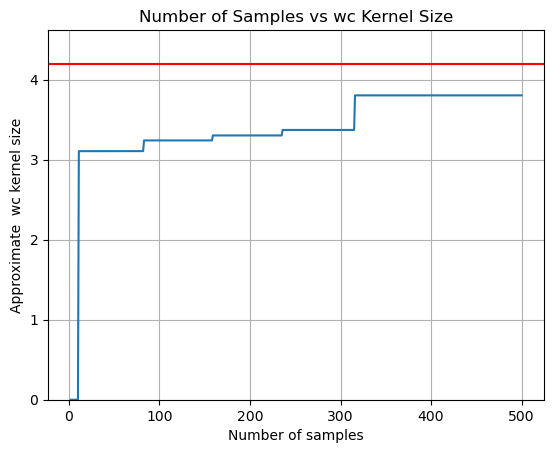

Total Max Kernel Size: 3.8044307231903076
Analytical Kernel Size: 4.2
Relative Error: -0.0941831611451649


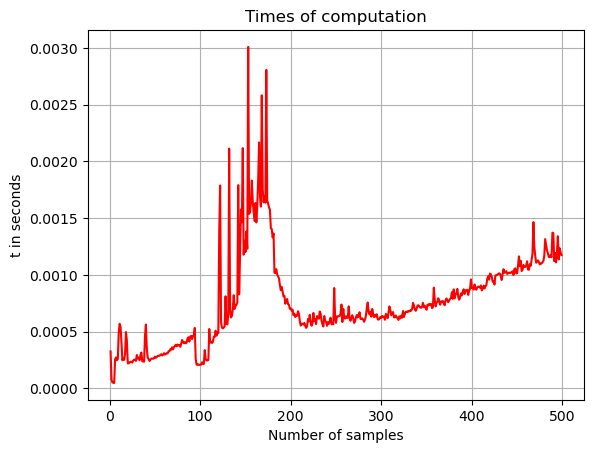

The last kernel size computation took 0.001173 seconds


In [ ]:
# check if P_{N(A)}(M_1) of first toy example set is symmetric

# Toy example 2

R = 2  # Radius of the ball
num_points = 500  # Number of points in the set M_1
A = np.diag([1, 1, 0])  # Transformation matrix
p=2
q=2
epsilon=1e-1
#analytical kersize
ker_size = 2*R+2*epsilon


# Generate points in B_R(0)
target_data = random_points_in_ball(R+epsilon, num_points)
input_data =  apply_forwardmodel(A, target_data)

# Set the range of k values
max_k = 500

wc_kersizes = []
times_comput = []
for k in range(1,max_k,1):
    input_data_k = input_data[0:k,:]
    target_data_k = target_data[0:k,:]
    t0 = time.time()
    wc_kersize_k = wc_kernelsize_nosym_batch_cuda(A, input_data_k, target_data_k, p_X=2,p_Y = 2, epsilon = epsilon)
    t1 = time.time()
    times_comput.append(t1-t0)
    wc_kersizes.append(wc_kersize_k)

wc_kersizef = wc_kersizes[-1]

plot_wckersize_conv(wc_kersizef, wc_kersizes, ker_size, max_k)

plot_times_comput(list(range(1,max_k,1)), times_comput)




### same but batched

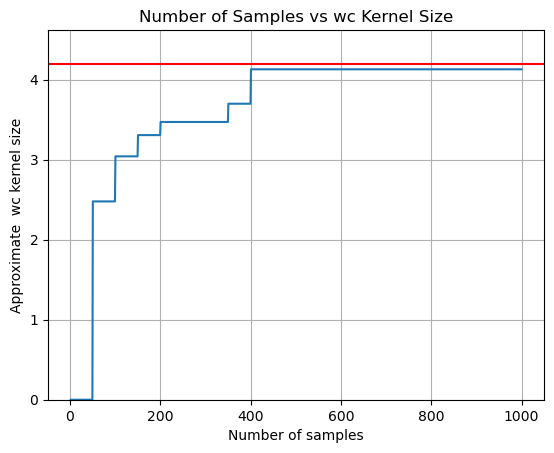

Total Max Kernel Size: 4.130290985107422
Analytical Kernel Size: 4.2
Relative Error: -0.016597384498232927


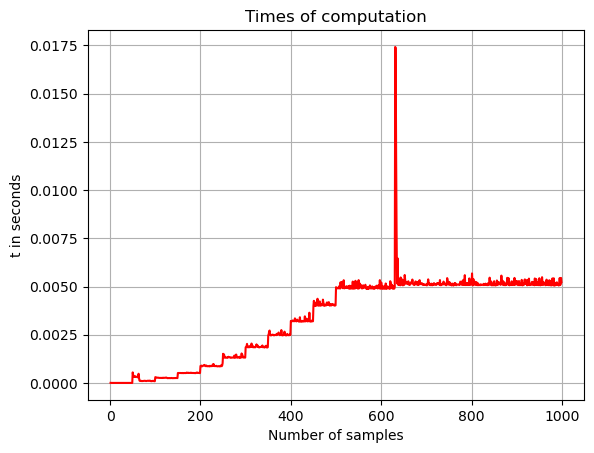

The last kernel size computation took 0.005226 seconds


In [37]:
R = 2  # Radius of the ball
num_points = 500  # Number of points in the set M_1
A = np.diag([1, 1, 0])  # Transformation matrix
p=2
q=2
epsilon=1e-1
#analytical kersize
ker_size = 2*R+2*epsilon


# Generate points in B_R(0)
target_data = random_points_in_ball(R+epsilon, num_points)
input_data =  apply_forwardmodel(A, target_data)

# Set the range of k values
max_k = 1000

wc_kersizes = []
times_comput = []
for k in range(1,max_k,1):
    input_data_k = input_data[0:k,:]
    target_data_k = target_data[0:k,:]
    t0 = time.time()
    wc_kersize_k = wc_kernelsize_nosym_perbatch_cuda(A, input_data_k, target_data_k, p_X=2, p_Y=2, epsilon = epsilon, batch_size= 50)
    t1 = time.time()
    times_comput.append(t1-t0)
    wc_kersizes.append(wc_kersize_k)

wc_kersizef = wc_kersizes[-1]

plot_wckersize_conv(wc_kersizef, wc_kersizes, ker_size, max_k)

plot_times_comput(list(range(1,max_k,1)), times_comput)


### Worst case Kersize with symetry assumption, parallelized

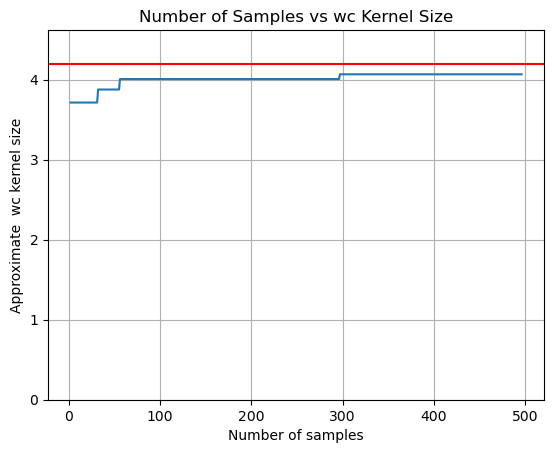

Total Max Kernel Size: 4.067592511324006
Analytical Kernel Size: 4.2
Relative Error: -0.03152559254190345


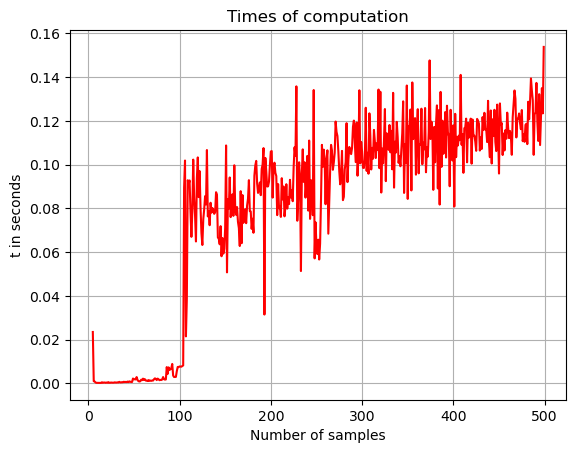

The last kernel size computation took 0.153756 seconds


In [43]:
# Toy example 2

R = 2  # Radius of the ball
num_points = 500  # Number of points in the set M_1
A = np.diag([1, 1, 0])  # Transformation matrix
p=2
q=2
epsilon=1e-1
#analytical kersize
ker_size = 2*R+2*epsilon


# Generate points in B_R(0)
target_data = random_points_in_ball(R+epsilon, num_points)
input_data =  apply_forwardmodel(A, target_data)

# Set the range of k values
max_k = 500

wc_kersizes = []
times_comput = []
for k in range(5,max_k,1):
    input_data_k = input_data[0:k,:]
    target_data_k = target_data[0:k,:]
    t0 = time.time()
    wc_kersize_k = wc_kernelsize_sym_batch_cuda(A, F_null=None,input_data= input_data_k, target_data=target_data_k, forwarded_target=torch.tensor(input_data_k), p_X=2,p_Y = 2, epsilon = epsilon)
    t1 = time.time()
    times_comput.append(t1-t0)
    wc_kersizes.append(wc_kersize_k)

wc_kersizef = wc_kersizes[-1]

plot_wckersize_conv(wc_kersizef, wc_kersizes, ker_size, max_k-4)

plot_times_comput(list(range(5,max_k,1)), times_comput)


### Same but per batch

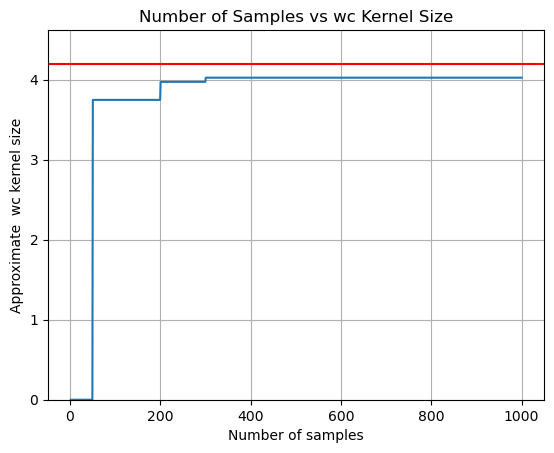

Total Max Kernel Size: 4.025526457991531
Analytical Kernel Size: 4.2
Relative Error: -0.04154131952582597


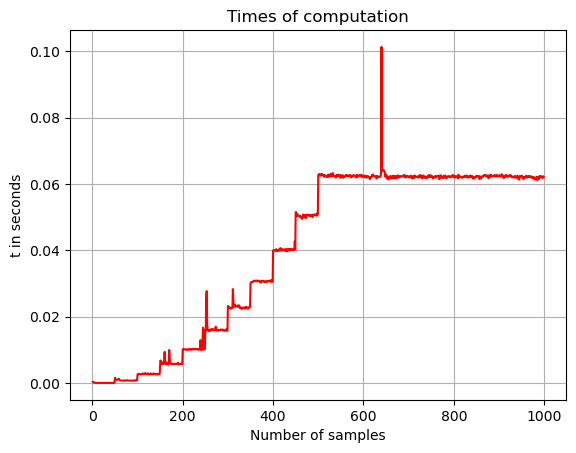

The last kernel size computation took 0.062121 seconds


In [47]:
R = 2  # Radius of the ball
num_points = 500  # Number of points in the set M_1
A = np.diag([1, 1, 0])  # Transformation matrix
p=2
q=2
epsilon=1e-1
#analytical kersize
ker_size = 2*R+2*epsilon


# Generate points in B_R(0)
target_data = random_points_in_ball(R+epsilon, num_points)
input_data =  apply_forwardmodel(A, target_data)

# Set the range of k values
max_k = 1000

wc_kersizes = []
times_comput = []
for k in range(1,max_k,1):
    input_data_k = input_data[0:k,:]
    target_data_k = target_data[0:k,:]
    t0 = time.time()
    wc_kersize_k = wc_kernelsize_sym_perbatch_cuda(A,None, input_data_k, target_data_k, torch.tensor(input_data_k), p_X=2, p_Y=2, epsilon = epsilon, batch_size= 50)
    t1 = time.time()
    times_comput.append(t1-t0)
    wc_kersizes.append(wc_kersize_k)

wc_kersizef = wc_kersizes[-1]

plot_wckersize_conv(wc_kersizef, wc_kersizes, ker_size, max_k)

plot_times_comput(list(range(1,max_k,1)), times_comput)


### Average kernel size

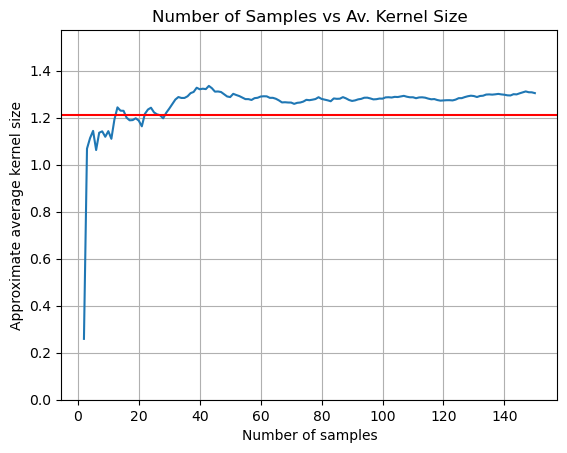

Total Max Kernel Size: 1.304871444390338
Analytical Kernel Size: 1.21
Relative Error: 0.0784061523887091


In [ ]:

# Toy example 4

R = 2  # Radius of the ball
num_points = 1000  # Number of points in the set M_1
A = np.diag([1, 1, 0])  # Transformation matrix
#analytical kersize
ker_size = 2*R
av_ker_size = 1.21 # value of av ker over pushforward measure is (R+epsilon)*sqrt(1/3)
p=2
q=2
epsilon=1e-1

# Generate points in B_R(0) use uniformly sampled points, 
# as av_ker_size is analytically caculated wrt the Lebesgue measure
target_data = random_uni_points_in_ball(R+epsilon, num_points)
#noise = np.random.uniform(0, epsilon, size=target_data.shape)
input_data =  apply_forwardmodel(A, target_data) #+noise

# Set the range of k values
max_k = 150

av_kersizes = []
for k in range(1,max_k,1):
    input_data_k = input_data[0:k,:]
    av_kersize_k = av_kernelsize(A, input_data_k, target_data, p,q, epsilon)
    #print(av_kersize_k)
    av_kersizes.append(av_kersize_k)

av_kersizef = av_kersizes[-1]

plot_avkersize_conv(av_kersizef, av_kersizes, av_ker_size, max_k)